## BERTの基礎

今ではGoogleの検索アルゴリズムにも利用されているBertについて、手を動かして触ってみます。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/tree/master/ml/lec/text/bert/bert_nb.ipynb)

### google colaboratory
<a href="https://colab.research.google.com/github/hiroshi0530/wa-src/tree/master/ml/lec/text/bert/bert_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 筆者の環境
筆者のOSはmacOSです。LinuxやUnixのコマンドとはオプションが異なります。

In [2]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6020


In [3]:
!python -V

Python 3.7.3


基本的なライブラリとkerasをインポートしそのバージョンを確認しておきます。

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np

import tensorflow as tf
from tensorflow import keras

import torch

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('tensorflow version : ', tf.__version__)
print('keras version : ', keras.__version__)
print('torch version : ', torch.__version__)

matplotlib version : 3.0.3
scipy version : 1.4.1
numpy version : 1.19.4
tensorflow version :  2.4.0
keras version :  2.4.0
torch version :  1.7.1


## 必要なライブラリのインストール

今回入門用にやってみる pytorch-transformersをインストールします。

```bash
pip install pytorch-transformers
```

BertModelの事前学習済みのモデルの詳細を確認します。

In [7]:
from pytorch_transformers import BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')
print(bert_model)

100%|████████████████████████████████████████████████████████████████████████████████| 440473133/440473133 [04:17<00:00, 1711144.45B/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

## 設定の確認

In [10]:
from pytorch_transformers import BertConfig

config = BertConfig.from_pretrained("bert-base-uncased")
print(config) 

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pad_token_id": 0,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [11]:
from transformers import BertForSequenceClassification

sc_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", return_dict=True)
print(sc_model.state_dict().keys())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

odict_keys(['bert.embeddings.position_ids', 'bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weigh

## 最適化アルゴリズム
今回は、最適化アルゴリズムに`AdamW`を採用します。  
`AdamW`は、オリジナルのAdamの重みの減衰に関する式を変更したものです。  
https://arxiv.org/abs/1711.05101

In [12]:
from transformers import AdamW

optimizer = AdamW(sc_model.parameters(), lr=1e-5)

## Tokenizerの設定
`BertTokenizer`により文章を単語に分割し、idに変換します。  
`BertForSequenceClassification`のモデルの訓練時には入力の他にAttention maskを渡す必要があるのですが、`BertTokenizer`によりこちらも得ることができます。

In [13]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
sentences = ["I love baseball.", "I hate baseball."]
tokenized = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)
print(tokenized)

x = tokenized["input_ids"]
attention_mask = tokenized["attention_mask"]


{'input_ids': tensor([[ 101, 1045, 2293, 3598, 1012,  102],
        [ 101, 1045, 5223, 3598, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])}


## ファインチューニング
事前に学習済みのモデルに対して、追加で訓練を行います。

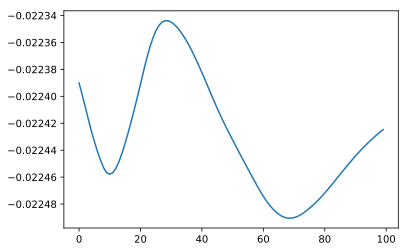

In [14]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

sc_model.train()
t = torch.tensor([1,0])  # 文章の分類

weight_record = []  # 重みを記録

for i in range(100):
    y = sc_model(x, attention_mask=attention_mask)
    loss = F.cross_entropy(y.logits, t)
    loss.backward()
    optimizer.step()

    weight = sc_model.state_dict()["bert.encoder.layer.11.output.dense.weight"][0][0].item()
    weight_record.append(weight)

plt.plot(range(len(weight_record)), weight_record)
plt.show()

追加の訓練により、重みが調整されていく様子が確認できます。

In [15]:
1 + 1

2

In [16]:
2 + 3

5

## 要約
### Self-atetntion
- inputとmemoryが同じAttention


### Multi-Head Attention
- Attention を並行に並べる
- それぞれのAtetntionはHeadっと呼ばれる